# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [127]:
import os
import json

import catboost
import lightgbm
import numpy as np
import optuna
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations, chain

%matplotlib inline

SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [87]:
PATH_TO_DATA = "../Data/copy-of-23-24-ml/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")
print(f"Размерность датасета: {df_train_features.shape}")
df_train_features.head()

Размерность датасета: (31698, 245)


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [88]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель (без предобработки признаков)
#### Обучим случайный лес, cделаем предсказания и оценим качество на отложенной части данных

In [89]:
%%time
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7754387258058622
Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453
CPU times: user 20.8 s, sys: 269 ms, total: 21 s
Wall time: 5.96 s


#### Сделаем функцию для проверки моделей

In [90]:
def test_model(model, df_features, df_targets, draw_plot=True):
    X = df_features
    y = df_targets["radiant_win"].astype("int8")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    valid_score = roc_auc_score(y_valid, y_pred)
    print("ROC-AUC score на отложенной части:", valid_score)
    
    if draw_plot:
        y_pred = model.predict(X_valid)
        cm = confusion_matrix(y_valid, y_pred)
        ConfusionMatrixDisplay(cm).plot()   

#### Проверим работу функции

ROC-AUC score на отложенной части: 0.7754387258058622


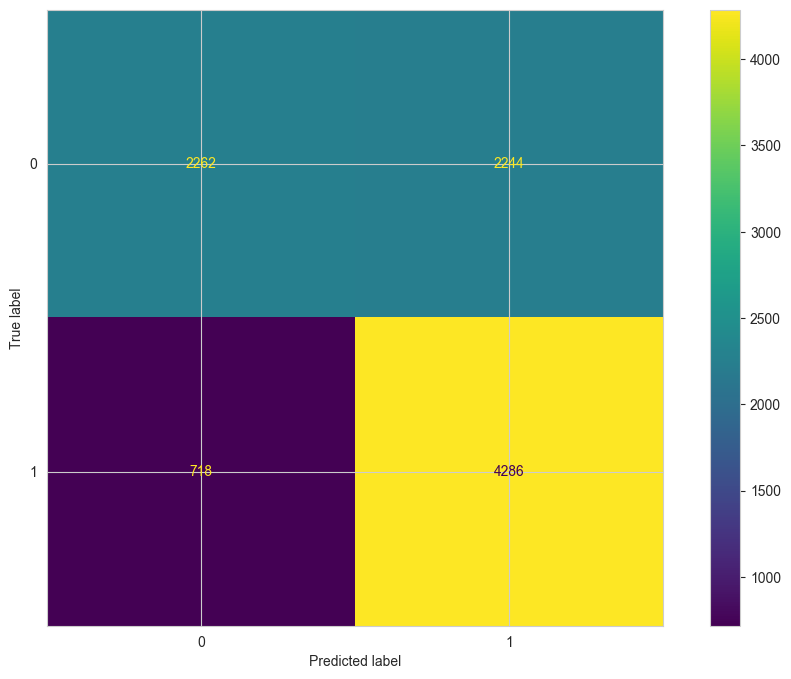

In [91]:
test_model(rf_model, df_train_features, df_train_targets)

## <left>Посылка

In [92]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")
X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [ ]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [93]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513
CPU times: user 2min 10s, sys: 1.35 s, total: 2min 11s
Wall time: 38.3 s


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_raw_data.jsonl` и `test_raw_data.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [94]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

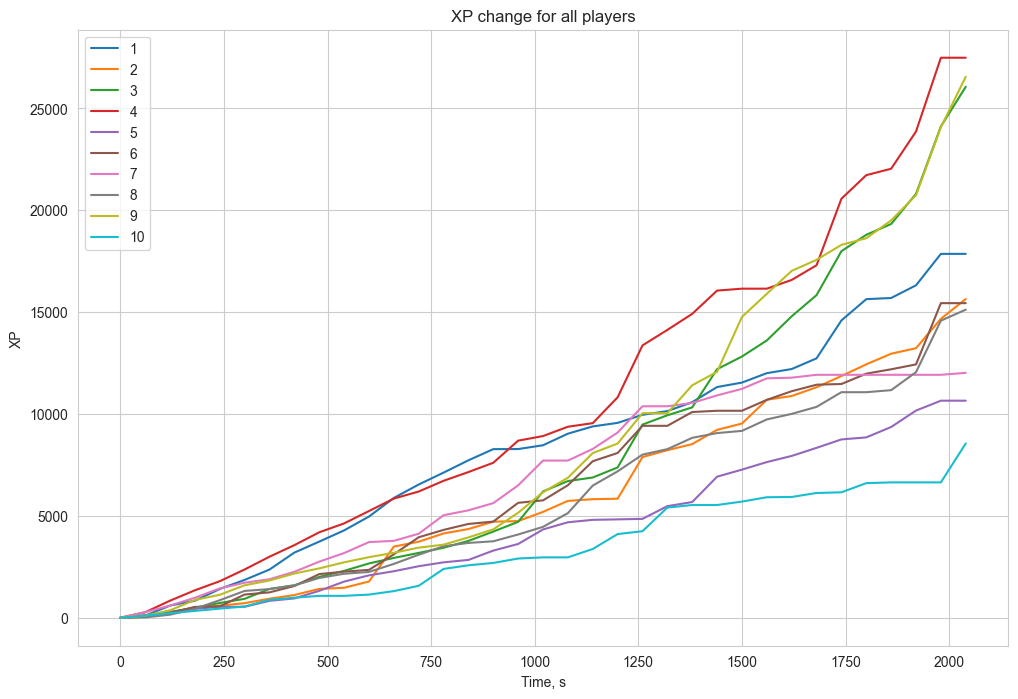

In [95]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [96]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [97]:
def add_new_features(df_features, matches_file, type = 'train'):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    n_matches_to_read = 31698
    if type == 'test':
        n_matches_to_read = 7977
        
    for match in read_matches(matches_file, n_matches_to_read):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [98]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [99]:
add_new_features(df_test_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "test_raw_data.jsonl"), type = 'test')

  0%|          | 0/7977 [00:00<?, ?it/s]

In [100]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235
CPU times: user 102 ms, sys: 180 ms, total: 282 ms
Wall time: 50.5 s


## Итак, начинается веселье


#### Выбираем категорильные колонки

In [101]:
category_columns = ['game_time', 'game_mode', 'lobby_type',
            'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
            'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']

Что будем делать далее?
1) Добавим колонку с суммарным количеством смертей, убийств, помощи, gold и т.д.
2) Добавим колонки diff_ (разница между суммарным количеством смертей, убийств и помощи и т.д. между 2 командами)
3) Добавим kde
4) Посмотрим на соотношение


In [102]:
def add_new_feature(df: pd.DataFrame):
    
    """Add new feature"""
    
    df_new = pd.DataFrame()
    def diff(a, b): 
        return a - b
    #Добавим сумму и разницу по разным переменным
    features = ('kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health','max_mana', 'stuns',
               'level', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation',
               'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed')
    for feature in features:
        df_new[f"sum_r_{feature}"] = df.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        df_new[f"sum_d_{feature}"] = df.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()
        
        df_new[f"diff_{feature}"] = df_new.apply(lambda x: diff(x[f"sum_r_{feature}"], x[f"sum_d_{feature}"]), axis=1)
    
    #Добавим kde
    def kde(kills, assists, deaths): 
        return (kills + assists) / (deaths + 1)
    
    teams = ['r','d']
    for team in teams:
            for player in range(1,6):
                df_new[f'{team}{player}_kde'] = df.apply(lambda x: kde(x[f'{team}{player}_kills'], x[f'{team}{player}_assists'],x[f'{team}{player}_deaths']), axis=1)
    # Добавим сумму и разницу KDE
    df_new[f"sum_r_kde"] = df_new.filter(regex=f'r._kde').apply(sum, axis=1).to_frame()
    df_new[f"sum_d_kde"] = df_new.filter(regex=f'd._kde').apply(sum, axis=1).to_frame()
    df_new[f"diff_kde"] = df_new.apply(lambda x: diff(x[f"sum_r_kde"], x[f"sum_d_kde"]), axis=1)
    
    # Можем еще посчитать соотношение для некоторых фич (Например для kde, потому что значения маленькие и diff не показателен)
    for feature in ['kde', "teamfight_participation"]:
        df_new[f'ratio_{feature}'] = df_new.apply(lambda x: x[f"sum_r_{feature}"] / max(x[f"sum_d_{feature}"] + x[f"sum_r_{feature}"], 1), axis=1)
    
    # Объединяем датафреймы
    df = pd.concat([df, df_new], axis=1)
    return df

#### Добавляем новые фичи в train и test

In [103]:
df_train_features_extended = add_new_feature(df_train_features_extended)
df_test_features_extended = add_new_feature(df_test_features_extended)

#### Проверим, что все добавилось

In [104]:
print(f"Количество фич в test: {df_test_features_extended.shape[1]}")
print(f"Количество фич в train: {df_train_features_extended.shape[1]}")

Количество фич в test: 326
Количество фич в train: 326


#### Посмотрим на базовой модели увеличился ли скор

ROC-AUC score на отложенной части: 0.8102316637590947


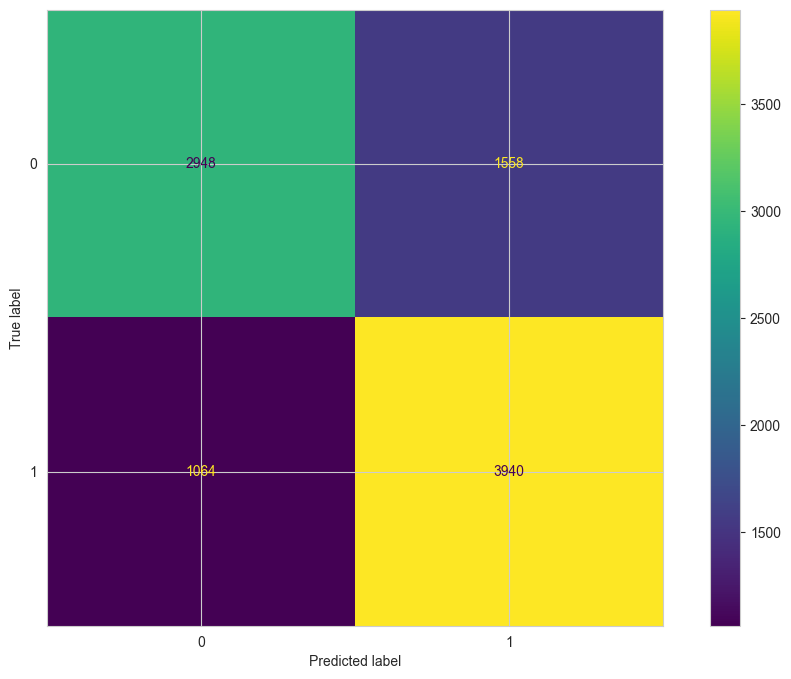

In [105]:
rf_model1 = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
test_model(rf_model, df_train_features_extended, df_train_targets)

#### Что ж даже на базовой модели без транформации данных скор стал выше! Это хорошо! 

#### Посмотрим на другие модели

In [27]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, cat_features = category_columns)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf)]

dict_for_dataframe = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

for i, model in enumerate([dt, rf, cat, etc, knn, xgb, lgbm, xgb_rf, lgbm_rf]): 
    scores = cross_val_score(model, df_train_features_extended, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    dict_for_dataframe[i] = scores
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.752821778558244
RandomForestClassifier: 0.8040229976268825
CatBoostClassifier: 0.821798353724458
ExtraTreesClassifier: 0.8042662819197837
KNeighborsClassifier: 0.7553419356191658
XGBClassifier: 0.8001686827026093
LGBMClassifier: 0.8132966224762912
XGBRFClassifier: 0.8132118492320419
LGBMClassifier: 0.8112181914752258


#### У catboost самый высокий скор, дальше попробуем подобрать для него гиперпараметры.

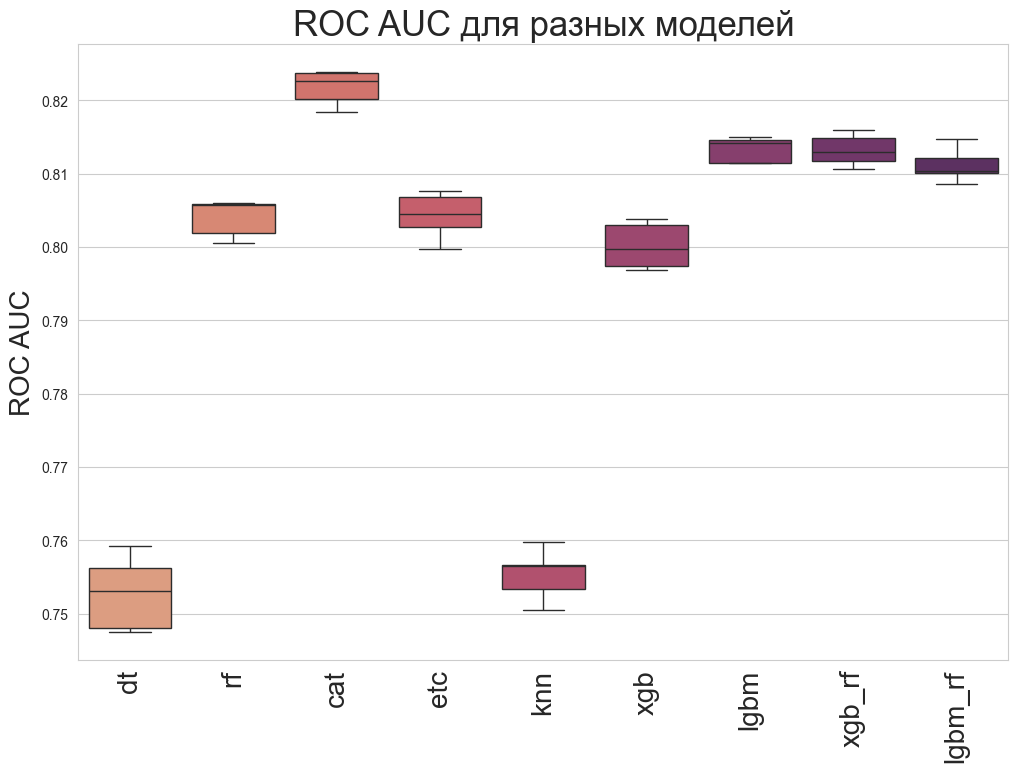

In [28]:
score_models = pd.DataFrame.from_dict(dict_for_dataframe, orient='columns')
score_models.columns = ['dt', 'rf', 'cat', 'etc', 'knn', 'xgb', 'lgbm', 'xgb_rf', 'lgbm_rf']
# Сделаем для наглядности график
ax = sns.boxplot(data=score_models, palette='flare')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("ROC AUC", size=20)
plt.title("ROC AUC для разных моделей", size=25)
plt.xticks(size=20)
plt.show()

#### Добавим данные из json файла

Какие?
1) item_uses - использование предмета (я так понимаю это то сколько раз были использованы предметы разные предметы) - будем смотреть сумму
2) ability uses - использование способностей - будем смотреть сумму
3) hero hits - хиты героя - будем смотреть сумму и длину
4) gold_reasons - по ключам "11": "Gold from destroying buildings", "12": "Gold from hero kills and assists", "13": "Gold from killing creeps",
  "14": "Gold from killing Roshan","15":"Gold from killing couriers"
5) gold_reasons - по ключам 1": "Gold lost from deaths",
  "2": "Gold spent on buybacks","5": "Gold from abandoned teammates"
5) Потом суммируем все по командам и смотрим на разницу

In [106]:
def add_new_features2(df_features, matches_file, type = 'train'):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    df_new = pd.DataFrame()
    
    n_matches_to_read = 31698
    if type == 'test':
        n_matches_to_read = 7977
        
    for match in read_matches(matches_file, n_matches_to_read):
        match_id_hash = match['match_id_hash']
        for i in range(0,5):
            player_r = match["players"][i]
            player_d = match["players"][i+4]
            df_features.loc[match_id_hash, f"r{i+1}_item_uses"] = len(player_r['item_uses'])
            df_features.loc[match_id_hash, f"d{i+1}_item_uses"] = len(player_d['item_uses'])
            df_features.loc[match_id_hash, f"r{i+1}_ability_uses"] = len(player_r['ability_uses'])
            df_features.loc[match_id_hash, f"d{i+1}_ability_uses"] = len(player_d['ability_uses'])
            df_features.loc[match_id_hash, f"r{i+1}_hero_hits"] = len(player_r['hero_hits'])
            df_features.loc[match_id_hash, f"d{i+1}_hero_hits"] = len(player_d['hero_hits'])
            
            #еще посчитаем сумму
            df_features.loc[match_id_hash, f"r{i+1}_item_uses_sum"] = len(player_r['item_uses'].values())
            df_features.loc[match_id_hash, f"d{i+1}_item_uses_sum"] = len(player_d['item_uses'].values())
            df_features.loc[match_id_hash, f"r{i+1}_ability_uses_sum"] = len(player_r['ability_uses'].values())
            df_features.loc[match_id_hash, f"d{i+1}_ability_uses_sum"] = len(player_d['ability_uses'].values())
            df_features.loc[match_id_hash, f"r{i+1}_hero_hits_sum"] = len(player_r['hero_hits'].values())
            df_features.loc[match_id_hash, f"d{i+1}_hero_hits_sum"] = len(player_d['hero_hits'].values())
            
            #разбираемся с gold_reasons
            gold_r = 0
            for k, v in player_r['gold_reasons'].items():
                if k in ['11', '12', '13', '14' '15']:
                    gold_r += v
                         
            gold_d = 0
            for k, v in player_d['gold_reasons'].items():
                if k in ['11', '12', '13', '14' '15']:
                    gold_d += v
                    
            df_features.loc[match_id_hash, f"r{i+1}_gold_reasons_kill"] = gold_r
            df_features.loc[match_id_hash, f"d{i+1}_gold_reasons_kill"] = gold_d  
            
            gold_r2 = 0
            for k, v in player_r['gold_reasons'].items():
                if k in ['1', '2', '5']:
                    gold_r2 += v
                         
            gold_d2 = 0
            for k, v in player_d['gold_reasons'].items():
                if k in ['1', '2', '5']:
                    gold_d2 += v
                    
            df_features.loc[match_id_hash, f"r{i+1}_gold_reasons_neg"] = gold_r2
            df_features.loc[match_id_hash, f"d{i+1}_gold_reasons_neg"] = gold_d2 
            
            
   #сделаем суммарные колонки по командам 
    def diff(a, b): 
        return a - b
            
    features = ('item_uses', 'ability_uses', 'hero_hits', 'gold_reasons_neg','gold_reasons_kill')
    for feature in features:
        df_new[f"sum_r_{feature}"] = df_features.filter(regex=f'r._{feature}').apply(sum, axis=1).to_frame()
        df_new[f"sum_d_{feature}"] = df_features.filter(regex=f'd._{feature}').apply(sum, axis=1).to_frame()      
        df_new[f"diff_{feature}"] = df_new.apply(lambda x: diff(x[f"sum_r_{feature}"], x[f"sum_d_{feature}"]), axis=1)
            
    # Объединяем датафреймы
    df_features = pd.concat([df_features, df_new], axis=1)
    return df_features
            

In [107]:
df_train_features_extended_cop = df_train_features_extended.copy()
df_test_features_extended_cop = df_test_features_extended.copy()

In [108]:
df_train_features_extended_cop = add_new_features2(df_train_features_extended_cop,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [109]:
df_test_features_extended_cop = add_new_features2(df_test_features_extended_cop,
                 os.path.join(PATH_TO_DATA,
                              "test_raw_data.jsonl"), type = 'test')

  0%|          | 0/7977 [00:00<?, ?it/s]

In [110]:
print(f'После добавления фич из json имеем {df_test_features_extended_cop.shape[1]} признак')

После добавления фич из json имеем 421 признак


#### Проверим модель (Увеличился ли скор после добавления признаков из json?)

In [111]:
scores = cross_val_score(cat, df_train_features_extended_cop, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{cat.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8236038394786525


Что ж скор стал немного выше!

#### Попробуем разобраться с Hero_id

In [112]:
y = df_train_targets["radiant_win"]
df_new_r = df_train_features[y].filter(regex=f'r._hero_id')
df_new_d = df_train_features[y == False].filter(regex=f'd._hero_id')
df_new_r['heros'] = df_new_r.apply(lambda x:x.tolist(), axis = 1)
df_new_d['heros'] = df_new_d.apply(lambda x:x.tolist(), axis = 1)

def comb_hero(x):
    x.sort()
    return list(combinations(x, 3))

df_new_r['heros']  = df_new_r['heros'].apply(lambda x: comb_hero(x))
df_new_d['heros']  = df_new_d['heros'].apply(lambda x: comb_hero(x))

heros_com_r = df_new_r['heros'].to_list()
heros_com_r = list(chain.from_iterable(heros_com_r))

heros_com_d = df_new_d['heros'].to_list()
heros_com_d = list(chain.from_iterable(heros_com_d))

heros_com = heros_com_r + heros_com_d

#Посчитаем количество вхождений каждой комбинации (найдем наиболее часто встречающиеся у победителей)
count = pd.Series(heros_com).value_counts()
sig_comb_hero = count[:100].index.tolist()

In [113]:
#БУдем проверять есть ли значимая комбинация героев у какой-то из команд
def check_com(x):
    count = 0
    for i in x:
        if i in sig_comb_hero:
            count += 1
    return count

df_train_features_extended_cop['r_hero_id_score'] = df_train_features_extended_cop.filter(regex=f'r._hero_id').apply(lambda x:x.tolist(), axis = 1).apply(lambda x: comb_hero(x)).apply(lambda x: check_com(x))
df_train_features_extended_cop['d_hero_id_score'] = df_train_features_extended_cop.filter(regex=f'd._hero_id').apply(lambda x:x.tolist(), axis = 1).apply(lambda x: comb_hero(x)).apply(lambda x: check_com(x))

df_test_features_extended_cop['r_hero_id_score'] = df_test_features_extended_cop.filter(regex=f'r._hero_id').apply(lambda x:x.tolist(), axis = 1).apply(lambda x: comb_hero(x)).apply(lambda x: check_com(x))
df_test_features_extended_cop['d_hero_id_score'] = df_test_features_extended_cop.filter(regex=f'd._hero_id').apply(lambda x:x.tolist(), axis = 1).apply(lambda x: comb_hero(x)).apply(lambda x: check_com(x))

def diff(a, b):
    return a - b

df_train_features_extended_cop[f"diff_hero_id_score"] = df_train_features_extended_cop.apply(lambda x: diff(x['r_hero_id_score'], x[f"d_hero_id_score"]), axis=1)
df_test_features_extended_cop[f"diff_hero_id_score"] = df_test_features_extended_cop.apply(lambda x: diff(x['r_hero_id_score'], x[f"d_hero_id_score"]), axis=1)

In [114]:
scores = cross_val_score(cat, df_train_features_extended_cop, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{cat.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8243375017731864


#### Посмотрим на наиболее важные признаки

In [115]:
feauture_importance = pd.DataFrame()
feauture_importance['name'] = cat.feature_names_
feauture_importance['importance'] =  cat.feature_importances_

In [116]:
feauture_importance.sort_values(by = 'importance', ascending = False)

,name,importance
262,diff_gold,11.876928
283,diff_level,3.779869
268,diff_xp,3.615343
247,diff_tower_kills,2.936294
271,diff_health,1.537353
...,...,...
303,sum_d_roshans_killed,0.000000
26,r1_roshans_killed,0.000000
93,r4_camps_stacked,0.000000
215,d4_firstblood_claimed,0.000000


In [118]:
bad_feature = feauture_importance.sort_values(by = 'importance')[:14].name.to_list()
df_train_features_cut = df_train_features_extended_cop.copy()
df_train_features_cut.drop(bad_feature, axis=1)

,game_time,game_mode,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,...,diff_hero_hits,sum_r_gold_reasons_neg,sum_d_gold_reasons_neg,diff_gold_reasons_neg,sum_r_gold_reasons_kill,sum_d_gold_reasons_kill,diff_gold_reasons_kill,r_hero_id_score,d_hero_id_score,diff_hero_id_score
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,3,10,15,7,2,0,7,5257,...,8.0,-480.0,-428.0,-52.0,11958.0,7059.0,4899.0,0,0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,101,0,0,0,0,176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,0,0,57,0,0,0,1,403,...,4.0,0.0,0.0,0.0,795.0,509.0,286.0,0,0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,1,0,119,0,3,3,5,3085,...,-4.0,-1378.0,-1238.0,-140.0,13033.0,14726.0,-1693.0,0,0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,2,2,12,3,1,2,9,3516,...,-6.0,-777.0,-492.0,-285.0,7436.0,7066.0,370.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,23,8,99,9,11,9,3,19850,...,-16.0,-11634.0,-8070.0,-3564.0,57932.0,74585.0,-16653.0,0,0,0.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,15,5,22,3,9,14,3,13914,...,-10.0,-3359.0,-4960.0,1601.0,56496.0,52034.0,4462.0,0,0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,4,0,1,1,2,1,0,4613,...,-4.0,-2132.0,-1016.0,-1116.0,12573.0,13297.0,-724.0,0,0,0.0


In [119]:
scores = cross_val_score(cat, df_train_features_cut, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{cat.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8243375017731864


Кажется лучше не стало:(

#### Попробуем нормализовать данные (сделаем трансформатор для данных)

In [120]:
numeric_columns = df_train_features_extended_cop.columns.to_list()
for i in category_columns:
    if i in numeric_columns:
        numeric_columns.remove(i)
print(f"Количество числовых колонок: {len(numeric_columns)}")
print(f"Количество категориальных колонок: {len(category_columns)}")
print(f"Всего колонок: {len(df_train_features_extended_cop.columns.to_list())}")

Количество числовых колонок: 411
Количество категориальных колонок: 13
Всего колонок: 424


In [121]:
x = df_train_features_extended_cop
y = df_train_targets["radiant_win"].astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(x, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), numeric_columns),
])
x_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_valid)

cat.fit(X_train, y_train)
y_pred = cat.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8224990801854744


Похоже, что трансформация не дает сильного улучшения скора

Посмотрим на корреляцию переменных (она есть и очень много между какими переменными). Попробуем что-то убрать, но думаю, что лучше не станет

In [124]:
cor_matr = df_train_features_extended_cop.corr(method="spearman")
s = cor_matr.unstack()
so = s.sort_values(kind="quicksort")
so

diff_deaths             diff_kills               -0.983482
diff_kills              diff_deaths              -0.983482
sum_r_gold_reasons_neg  sum_r_deaths             -0.963810
sum_r_deaths            sum_r_gold_reasons_neg   -0.963810
sum_d_kills             sum_r_gold_reasons_neg   -0.961980
                                                    ...   
r1_item_uses_sum        r1_item_uses_sum          1.000000
d1_item_uses_sum        d1_item_uses              1.000000
                        d1_item_uses_sum          1.000000
d1_ability_uses         d1_ability_uses           1.000000
diff_hero_id_score      diff_hero_id_score        1.000000
Length: 179776, dtype: float64

In [125]:
drop_columns = ['sum_r_level', 'sum_d_level', 'r1_level', 'r2_level', 'r3_level', 'r4_level', 'r5_level', 'd1_level', 'd2_level', 'd3_level', 'd4_level', 'd5_level']
df_train_features_cut = df_train_features_extended_cop.copy()
df_train_features_cut.drop(drop_columns, axis=1)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,diff_hero_hits,sum_r_gold_reasons_neg,sum_d_gold_reasons_neg,diff_gold_reasons_neg,sum_r_gold_reasons_kill,sum_d_gold_reasons_kill,diff_gold_reasons_kill,r_hero_id_score,d_hero_id_score,diff_hero_id_score
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,8.0,-480.0,-428.0,-52.0,11958.0,7059.0,4899.0,0,0,0.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,4.0,0.0,0.0,0.0,795.0,509.0,286.0,0,0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,-4.0,-1378.0,-1238.0,-140.0,13033.0,14726.0,-1693.0,0,0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,-6.0,-777.0,-492.0,-285.0,7436.0,7066.0,370.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,-16.0,-11634.0,-8070.0,-3564.0,57932.0,74585.0,-16653.0,0,0,0.0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,-10.0,-3359.0,-4960.0,1601.0,56496.0,52034.0,4462.0,0,0,0.0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,-4.0,-2132.0,-1016.0,-1116.0,12573.0,13297.0,-724.0,0,0,0.0


In [126]:
scores = cross_val_score(cat, df_train_features_cut, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"{cat.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8243375017731864


#### Ниже остаивила ячейки с кодом, где пыталась подобрать гиперпараметры

In [133]:
params = {'iterations': [500, 600, 700, 800, 900, 1000],
          'depth': [4, 5, 6, 7 ,8],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': [0.3, 0.5, 0.8, 0.9, 1, 2],
          'random_seed': [SEED],
          'learning_rate': [0.012, 0.015, 0.017, 0.019, 0.025],
          'cat_features' : [category_columns],
          'verbose': [False]
         }
grid = GridSearchCV(estimator=cat, param_grid=params, scoring="roc_auc", cv=cv, n_jobs=-1)

In [145]:
grid.fit(df_train_features_extended_cop,y)
best_param = grid.best_params_

KeyboardInterrupt: 

In [142]:
#Попробуем подобрать параметры с помощью Optuna
def objective(trial):
   """
   Objective function to be optimized.
   """
   param = {
       "verbose": 1,
       "learning_rate": trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.002),
       "depth": trial.suggest_int('depth', 5, 15),
       "l2_leaf_reg": trial.suggest_discrete_uniform('l2_leaf_reg', 0.5, 2.5, 0.2),
       "min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 10, 12, 14, 16, 20, 25, 32]),
       "iterations": trial.suggest_int('iterations', 650, 1000),
       "random_state": SEED,
       "cat_features": category_columns
   }

   model = catboost.CatBoostClassifier(**param)
   scores = cross_val_score(model, df_train_features_extended_cop, y, cv=cv, scoring="roc_auc", n_jobs=15)
    
   return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=14)

[I 2024-04-05 11:58:24,133] A new study created in memory with name: no-name-c59a1ec1-3469-44b5-b8a1-a96095887c42
[W 2024-04-05 12:02:11,429] Trial 3 failed with parameters: {'learning_rate': 0.011, 'depth': 13, 'l2_leaf_reg': 1.1, 'min_child_samples': 14, 'iterations': 704} because of the following error: KeyboardInterrupt('').
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/julia_dino/Documents/IB/ML/BI_ML_2024/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 463, in _process_worker
    r = call_item()
        ^^^^^^^^^^^
  File "/Users/julia_dino/Documents/IB/ML/BI_ML_2024/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 291, in __call__
    return self.fn(*self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/julia_dino/Documents/IB/ML/BI_ML_2024/venv/lib/python3.11/site-packages/joblib/parallel.py", line 589, in __call

KeyboardInterrupt: 

In [144]:
cat = catboost.CatBoostClassifier(verbose=False, iterations=1000,
                           depth=7,learning_rate=0.019, loss_function= 'CrossEntropy', l2_leaf_reg = 0.9, random_seed=SEED, cat_features = category_columns)
scores = cross_val_score(cat, df_train_features_extended_cop, y, cv=cv, scoring="roc_auc", n_jobs=15)
print(f"{cat.__class__.__name__}: {scores.mean()}")

CatBoostClassifier: 0.8236314635407535


In [138]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, cat_features = category_columns)
y = df_train_targets["radiant_win"].astype("int8")
cat.fit(df_train_features_extended_cop, y)
X_test = df_test_features_extended_cop
y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                             index=df_test_features_extended_cop.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-05_11-53-56.csv
